In [199]:
import json
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import multiprocessing
import numpy as np
import shutil 
import preprocessor as p

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS 

# Set of stopwords from Stone, Denis, Kwantes
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk import classify
from nltk import NaiveBayesClassifier

from textblob import TextBlob
import itertools 

import pickle

from sklearn.linear_model import LinearRegression
import pandas_profiling

import statsmodels.api as sm

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vinhtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%run helper_functions.py

### Pre-processing

In [155]:
#Combine all files into one

with open('output_file.txt','wb') as wfd:
    for f in ['twitter_data.txt','twitter_data_c2.txt',
              'twitter_data_c2_pt2.txt','twitter_data_c2_pt3.txt', 
              'twitter_data_c2_pt4.txt', 'twitter_data_c2_pt5.txt', 
              'twitter_data_c2_pt6.txt', 'twitter_data_c2_pt7.txt',
             'twitter_data_c2_pt8.txt','twitter_data_c2_pt9.txt',
              'twitter_data_c2_pt10.txt','twitter_data_c2_pt11.txt']:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)

### Read in and subset data

In [225]:
#read in data as chunks
df = pd.read_json('output_file.txt', lines = True)

In [226]:
#only keep variables needed
df = df[["id_str", "text", "place", "coordinates", "created_at", "lang", "possibly_sensitive","retweeted" ]]

In [227]:
#don't include retweets
keyword_column_boolean(df, ['RT'])
print("full df:", len(df))
df = df[df['RT']==False]
print("after RT removal:", len(df))

full df: 97816
after RT removal: 53176


In [229]:
#booleans for each diet
diet_list = ['keto','whole30','glutenfree','mediterraneandiet','lowfat', 'atkins', 'paleo', 'celeryjuice']
keyword_column_boolean(df, diet_list)

In [231]:
#fix Place field
#fill None with 0
filled = df['place'].fillna(0)
#replace old column
df["place"] = filled

In [232]:
# #mask
place = df[df['place'] != 0]
place.reset_index(inplace=True)

#pull out bounding box from place
df_place = [i for i in df["place"] if i] 
df_place_2 = pd.DataFrame(list(np.array(df_place)))

city = df_place_2[["name","country_code"]]

bounding_box = pd.DataFrame(list(np.array(df_place_2["bounding_box"])))
bounding_box.rename(columns={'coordinates': 'bounding_box'}, inplace=True)

#add to original df to get df we want
df_location = pd.concat([place, bounding_box], axis=1, join='inner')
df_location = pd.concat([df_location, city], axis=1, join='inner')
print("has location data:", len(df_location))

has location data: 2692


In [426]:
#limit to only english for analysis
df_location = df_location[df_location['lang'] == 'en']
print("after english removal df_location:", len(df_location))
df_eng = df[df['lang'] == 'en']
print("after english removal df_eng:", len(df))

after english removal df_location: 2154
after english removal df_eng: 53176


In [161]:
#limit to only US for analysis
df_location = df_location[df_location['country_code'] == 'US']
print("after non-US removal:", len(df_location))

after non-US removal: 1494


In [427]:
#clean tweets - remove URLs, smileys, mentions, emojis

p.set_options(p.OPT.URL, p.OPT.SMILEY, p.OPT.MENTION, p.OPT.EMOJI) 


text_list = list(df_location["text"])

clean_text_list = []
for tweet in text_list:   
    clean_text_list.append(p.clean(tweet))

df_location["text_clean"] = clean_text_list 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [164]:
#manually delete for now. eventually would like to do a hieararchy where if place is missing 
# and coordinates is not, fill with coordinates
df_location = df_location[df_location["id_str"] != 1141697585700204544]

#fix index
df_location2 = df_location.reset_index()
df_location3 = df_location2.drop(["index", "level_0"], axis = 1)
df_location3['index'] = df_location3.index

#final df
df_clean = df_location3

### create dataframe with clean text and index for merging


In [166]:
# create a new frame with only the cleaned text (tweet) and index
documents_v = df_clean[['text_clean', "index"]]

print(documents_v[:10])

                                          text_clean  index
0  you should make Keto meal versions of food you...      0
1  Today is a good day #sanantonio #glutenfree #h...      1
2  Have you tried our new Classic Cheeseburger? O...      2
3  I love when I walk into a grocery store for th...      3
4  Sausage and Black Olive pizzas in and do Antip...      4
5  I just had a customer tell me that the keto di...      5
6  This just made me laugh! Keto friends know. Th...      6
7  Perfect sunny Seattle day at my favorite brewe...      7
8  Enjoying a Grapefruit IPA on a perfect sunny S...      8
9  It's a hot trend now smh. They'd keto water an...      9


### NLP SENTIMENT ANALYSIS

In [176]:
# using TextBlob calculate polarity and sentiment on clean tweets
documents_v['polarity'] = documents_v['text_clean'].map(get_tweet_polarity);
documents_v['sentiment'] = documents_v['polarity'].map(get_tweet_sentiment);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Linear Regression

In [187]:
# read in CDC data
cities = pd.read_csv('500_Cities__City-level_Data__GIS_Friendly_Format___2018_release.csv')


In [188]:
#Workaround to get coordinates from place

list2 = [item[0] for item in df_clean["bounding_box"]]
list3 = [item[0] for item in list2]
list4 = [item[::-1] for item in list3]

df_clean["coordinate_point"] = list4

In [189]:


if __name__ == "__main__":

    # Load US_coord_dict
    US_coord_dict = load_US_coord_dict()

    # Create a new column called 'closest_major_city'
    df_clean['closest_major_city'] = df_clean.apply(lambda row: get_closest_major_city_for_US(row), axis=1)
    

In [190]:
# clean DF to use is df_location3 and document_v for scores
# documents_v.drop(['text_clean'] ,axis=1, inplace=True)
prediction = pd.concat([df_clean, documents_v], axis=1)
prediction2 = prediction.groupby(['closest_major_city','sentiment'])['polarity'].mean()
prediction2 = pd.DataFrame(prediction2)
prediction3 = prediction2.pivot_table(index='closest_major_city', columns="sentiment", values='polarity')
prediction3 =  prediction3.rename_axis(None, axis=1).reset_index() 
prediction4 = prediction3.rename(columns = {"index": 'PlaceName'})
city = prediction4["closest_major_city"].str.split(',', expand=True)
city.rename(columns = {0:"closest_city", 1: "closest_state"}, inplace=True)
prediction5 = pd.concat([city, prediction4], axis=1, join='inner')
prediction6 = pd.merge(prediction5, cities, left_on='closest_city', right_on='PlaceName')   

In [191]:
prediction6.head()

,closest_city,closest_state,closest_major_city,negative,neutral,positive,StateAbbr,PlaceName,PlaceFIPS,Population2010,...,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation
0,Abilene,TX,"Abilene, TX",NaN,NaN,0.160000,TX,Abilene,4801000,117063,...,"(33.6, 34.1)",3.2,"( 3.1, 3.2)",3.3,"( 3.3, 3.4)",15.7,"(14.6, 16.9)",15.6,"(14.5, 16.8)","(32.45465108980, -99.7383043723)"
1,Akron,OH,"Akron, OH",NaN,0.0,0.327500,OH,Akron,3901000,199110,...,"(43.2, 43.6)",4.2,"( 4.1, 4.2)",4.1,"( 4.0, 4.2)",21.6,"(20.6, 22.5)",21.5,"(20.6, 22.4)","(41.08014449420, -81.5219213688)"
2,Albuquerque,NM,"Albuquerque, NM",-0.187500,0.0,NaN,NM,Albuquerque,3502000,545852,...,"(32.3, 32.5)",2.9,"( 2.8, 2.9)",2.9,"( 2.8, 2.9)",12.5,"(12.1, 13.0)",12.6,"(12.2, 13.1)","(35.10550257710, -106.647447696)"
3,Alexandria,VA,"Alexandria, VA",-0.166667,0.0,0.278669,VA,Alexandria,5101000,139966,...,"(30.7, 31.2)",2.0,"( 1.9, 2.0)",2.3,"( 2.2, 2.3)",9.0,"( 8.2, 10.0)",9.2,"( 8.4, 10.2)","(38.81873515570, -77.0867762661)"
4,Alhambra,CA,"Alhambra, CA",-0.100000,0.0,NaN,CA,Alhambra,600884,83089,...,"(37.7, 38.3)",2.5,"( 2.4, 2.6)",2.3,"( 2.3, 2.4)",9.2,"( 8.4, 10.0)",9.1,"( 8.4, 9.8)","(34.08397343830, -118.135514119)"


In [375]:
#drop adjusted variables, obviously highly correlated with crude measures. 

prediction7 = prediction6.filter(items=["PlaceName", "negative", "neutral", "positive",
"Population2010",
# "ACCESS2_AdjPrev",
# "ARTHRITIS_AdjPrev",
# "BINGE_AdjPrev",
# "BPHIGH_AdjPrev",
# "BPMED_AdjPrev",
# "CANCER_AdjPrev",
# "CASTHMA_AdjPrev",
# "CHD_AdjPrev",
# "CHECKUP_AdjPrev",
# "CHOLSCREEN_AdjPrev",
# "COLON_SCREEN_AdjPrev",
# "COPD_AdjPrev",
# "COREM_AdjPrev",
# "COREW_AdjPrev",
# "CSMOKING_AdjPrev",
# "DENTAL_AdjPrev",
# "DIABETES_AdjPrev",
# "HIGHCHOL_AdjPrev",
# "KIDNEY_AdjPrev",
# "LPA_AdjPrev",
# "MAMMOUSE_AdjPrev",
# "MHLTH_AdjPrev",
"OBESITY_AdjPrev",
# "PAPTEST_AdjPrev",
# "PHLTH_AdjPrev",
# "SLEEP_AdjPrev",
# "STROKE_AdjPrev",
# "TEETHLOST_AdjPrev"
])

In [446]:
bins = [0, 25, 40,  np.inf]
names = [1, 2, 3]

prediction7['obesityrange'] = pd.cut(prediction7['OBESITY_AdjPrev'], bins, labels=names)

In [447]:
pandas_profiling.ProfileReport(prediction7)

Number of variables,7
Number of observations,294
Total Missing (%),16.7%
Total size in memory,16.5 KiB
Average record size in memory,57.4 B
Numeric,4
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [448]:
#Linear Regression
prediction8 = prediction7[(prediction7["positive"] > 0) 
#                           & (prediction7["negative"])
                         ]

In [449]:
prediction8

,PlaceName,negative,neutral,positive,Population2010,OBESITY_AdjPrev,obesityrange
0,Abilene,NaN,NaN,0.160000,117063,36.0,2
1,Akron,NaN,0.0,0.327500,199110,36.5,2
3,Alexandria,-0.166667,0.0,0.278669,139966,24.9,1
5,Allentown,NaN,0.0,0.251420,118032,37.8,2
6,Amarillo,NaN,0.0,0.565714,190695,33.8,2
7,Anaheim,NaN,NaN,0.900000,336265,24.2,1
9,Ann Arbor,-0.800000,0.0,0.408681,113934,25.6,2
11,Arlington,NaN,0.0,0.487500,365438,31.9,2
13,Atlanta,-0.129398,0.0,0.444043,420003,29.1,2
14,Augusta,NaN,NaN,0.328906,195844,36.4,2


In [450]:
y = prediction8["obesityrange"]
X = prediction8.drop(["OBESITY_AdjPrev", "obesityrange", "PlaceName", "neutral", "negative", "Population2010"], axis=1).astype(float)
X['const'] = 1

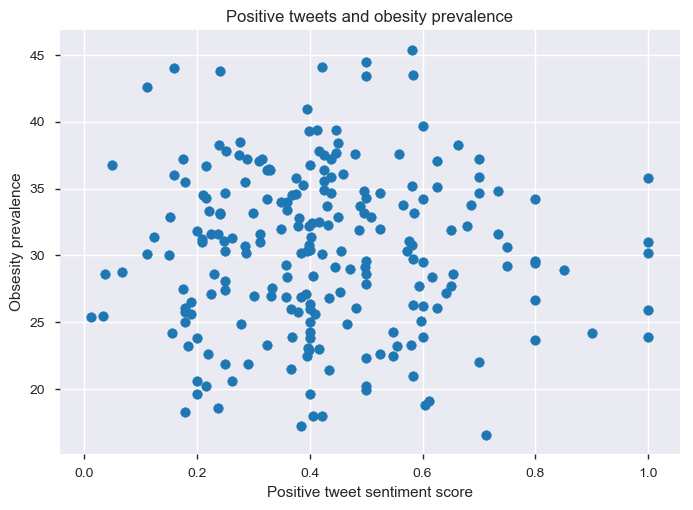

In [423]:
#look at relationship of positive tweets and obesity

plt.scatter(X["positive"], y)
plt.xlabel("Positive tweet sentiment score")
plt.ylabel("Obsesity prevalence")
plt.title("Positive tweets and obesity prevalence")
plt.savefig('Positive_tweets_obesity.png')

Text(0.5, 1.0, 'Positive tweets and obesity range prevalence')

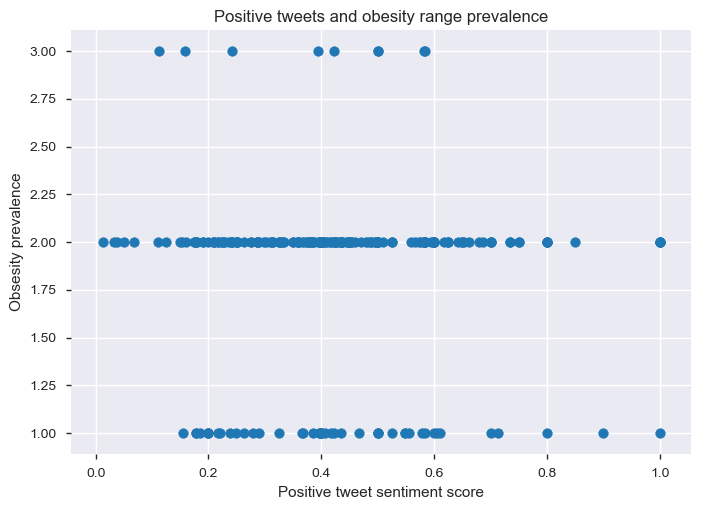

In [453]:
plt.scatter(X["positive"], y)
plt.xlabel("Positive tweet sentiment score")
plt.ylabel("Obsesity prevalence")
plt.title("Positive tweets and obesity range prevalence")
# plt.savefig('Positive_tweets_obesity.png')

(array([ 6., 23., 34., 52., 45., 28., 16., 10.,  2.,  5.]),
 array([0.0125 , 0.11125, 0.21   , 0.30875, 0.4075 , 0.50625, 0.605  ,
        0.70375, 0.8025 , 0.90125, 1.     ]),
 <a list of 10 Patch objects>)

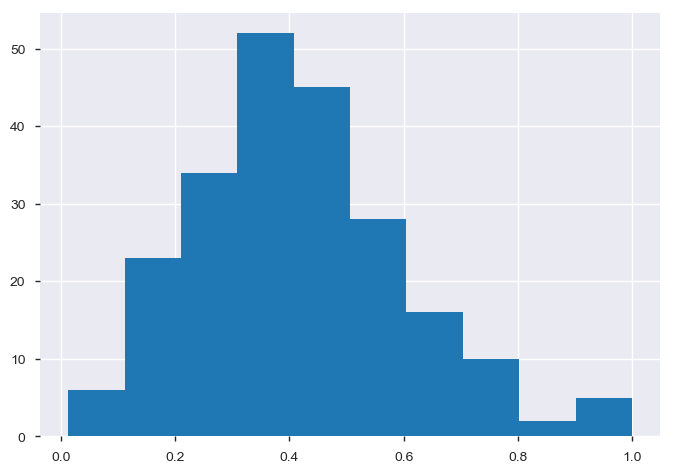

In [412]:
plt.hist(X["positive"])

(array([ 8., 14., 26., 33., 34., 39., 34., 23.,  2.,  8.]),
 array([16.6 , 19.48, 22.36, 25.24, 28.12, 31.  , 33.88, 36.76, 39.64,
        42.52, 45.4 ]),
 <a list of 10 Patch objects>)

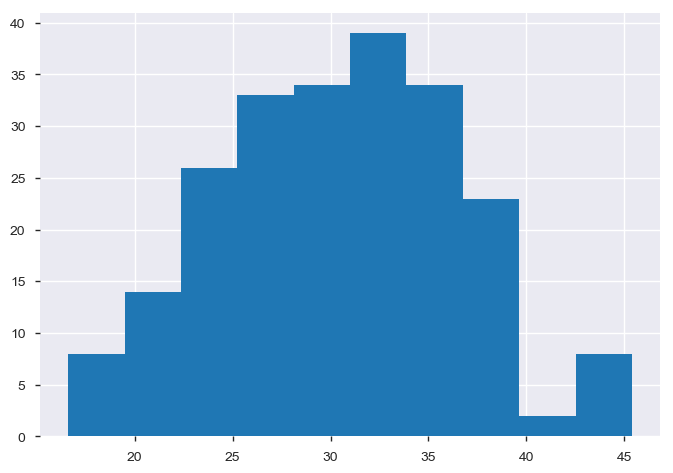

In [413]:
plt.hist(y)

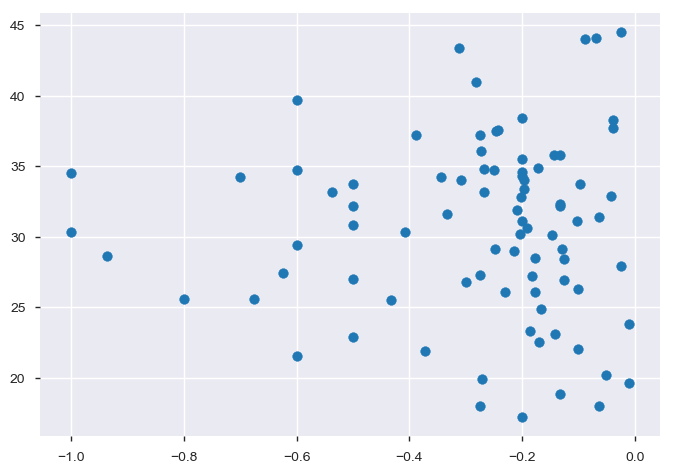

In [402]:
plt.scatter((X["negative"]), y)

In [457]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

logreg.fit(X,y)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [459]:
logreg.score(X,y)

0.746606334841629

In [460]:
logreg.get_params()

{'C': 100000.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [451]:
#fit the model
model = sm.OLS(endog=y, exog=X).fit()

In [452]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           obesityrange   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1762
Date:                Wed, 03 Jul 2019   Prob (F-statistic):              0.675
Time:                        14:09:50   Log-Likelihood:                -148.09
No. Observations:                 221   AIC:                             300.2
Df Residuals:                     219   BIC:                             307.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
positive      -0.0689      0.164     -0.420      0.675      -0.392       0.255
const          1.8573      0.077     24.228      0.000       1.706       2.008
==============================================================================
Omnibus:                       11.047   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.429
Skew:                          -0.488   Prob(JB):                      0.00330
Kurtosis:                       3.536   Cond. No.                         6.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""